# SPE homework 1
## imports and functions

In [112]:
from pandas import read_csv
import numpy as np
from matplotlib import pyplot as plt
from numpy import mean, min, max, median, quantile
from scipy.stats import binom, norm, t as student
from math import sqrt, pow, floor, ceil, exp

# define corrected functions for std and variance
def variance(values):
    return np.var(values, ddof=1)
def std(values):
    return np.std(values, ddof=1)

def quantile_confidence(values, q, confidence):
    # return tuple (lower, upper) of values
    values = sorted(values)
    n = len(values)
    if n > 100:
        # approximate
        z = norm.ppf((1+confidence)/2)
        j = floor(n*q-z*sqrt(n*q*(1-q)))
        k = ceil(n*q+z*sqrt(n*q*(1-q)))+1
        return (values[j], values[k], confidence)

    # with n <= 100, use binom cdf formula
    results = []
    binoms = [binom.cdf(i, n, q) for i in range(0, n)]
    for j in range(1, n):
        for k in range(j, n):
            val = binoms[k] - binoms[j]
            if val >= confidence:
                results.append((j, k, val))

    # sort by smallest interval and highest confidence value
    results = sorted(results, key=lambda x: (x[1]-x[0], -x[2]))
    best = results[0]
    return (values[best[0]], values[best[1]])

def mean_confidence_asymptotic(values, confidence):
    # when variables iid and high n
    n = len(values)
    z = norm.ppf((1+confidence)/2)
    s = std(values)
    m = mean(values)
    j = m - z*s/sqrt(n)
    k = m + z*s/sqrt(n)
    return (j, k)

def CoV(values):
    # Coeff of variation (not defined on heavy tailed sets, because variance=>inf)
    return std(values)/mean(values)

def MAD(values):
    # mean absolute deviation, always defined
    n = len(values)
    m = mean(values)
    return sum([abs(x-m) for x in values])/n

def lorenz_gap(values):
    # always defined, the best
    return MAD(values)/(2*mean(values))

def JFI(values):
    # Jain Fairness Index (same problems as CoV?)
    return 1/(1+pow(CoV(values), 2))

def bootstrap(values, confidence, func, r0=25):
    R = ceil(2*r0/(1-confidence))
    n = len(values)
    Tvs = []
    for r in range(R):
        V = np.random.choice(values, size=(n,))
        Tv = func(V)
        Tvs.append(Tv)
    Tvs = sorted(Tvs)
    interval = (Tvs[r0], Tvs[R-r0-1])
    low = 0
    high = 0
    for tv in Tvs:
        if tv < interval[0]:
            low += 1
        if tv > interval[1]:
            high += 1
    return interval

def success_probability_confidence_normal(values, confidence):
    n = len(values)
    z = sum(values)
    eta = norm.ppf((1+confidence)/2)
    lower = z/n - eta/n * sqrt(z* (1 - z/n))
    upper = z/n + eta/n * sqrt(z* (1 - z/n))
    return (lower, upper)
    
def success_probability_confidence_three(values, confidence):
    n = len(values)
    lower = 0
    upper = 1 - pow(((1-confidence)/2), 1/n)
    return (lower, upper)

## Import data

In [113]:
data = 'data'
data_ex1 = read_csv(f'{data}\\data_ex1.csv', header=None)
data_ex2 = read_csv(f'{data}\\data_ex2.csv', header=None)
data_ex3 = read_csv(f'{data}\\data_ex3.csv', header=None)
data_ex4 = read_csv(f'{data}\\data_ex4.csv', header=None)
data_ex5 = read_csv(f'{data}\\data_ex5.csv', header=None)

## Exercise 1

1. To compute the confidence interval for the mean, knowing that the datasamples were iid, we used the formula of Theorem 2.1. In particular, given the large number of elements the right formula to use was the approximation:<img src=https://i.imgur.com/F5gyw82.png width=200 height=300 >where _p_ is 0.5 for the median and η is the quantile of the normal distribuition in $\dfrac{1+γ}{2}$ (we computed it but it could be approximated as 1.96 for γ= 0.95).
2. For the mean, knowing the data samples to be iid and large in number, we used the CI for the mean in the asymptotic case described in Theorem 2.2.<img src=https://i.imgur.com/yxyLzP5.png width=100 height=200>Again η is the quantile of the normal distribuition in $\dfrac{1+γ}{2}$

In [114]:
values = data_ex1.to_numpy()[:, 0]
values = sorted(values)
print("Median:", median(values))
interval = quantile_confidence(values, 0.5, 0.95)
print(f"Median CI at 0.95: [{interval[0]} , {interval[1]}]")

# 1000 iid values, no heavy tail => asymptotic
print(f"Mean: {mean(values)}")
interval = mean_confidence_asymptotic(values, 0.95)
print(f"Mean CI at 0.95: [{interval[0]} , {interval[1]}]")
interval = mean_confidence_asymptotic(values, 0.99)
print(f"Mean CI at 0.99: [{interval[0]} , {interval[1]}]")

Median: 0.40319100366316096
Median CI at 0.95: [0.384475528575523 , 0.4171819583272271]
Mean: 0.41020458058272363
Mean CI at 0.95: [0.398868829144219 , 0.42154033202122826]
Mean CI at 0.99: [0.3953068778885086 , 0.42510228327693866]


## Exercise 2

In [115]:
rows = data_ex2.to_numpy()
# 200 values => asymptotic again
values = rows[0]
print(f"Mean: {mean(values)}")
interval = mean_confidence_asymptotic(values, 0.95)
print(f"Mean CI at 0.95: [{interval[0]} , {interval[1]}]")

outside = 0
inside = 0
for i in range(1, len(rows)):
    m = mean(rows[i])
    if m >= interval[0] and m <= interval[1]:
        inside += 1
    else:
        outside += 1

print(f"Ratio of rows with mean inside CI 0.95: {inside/(inside+outside)}")

Mean: 3.175048214082969
Mean CI at 0.95: [2.9374928534666043 , 3.4126035746993337]
Ratio of rows with mean inside CI 0.95: 0.6693333333333333


## Exercise 3

CoV: 1.001469136252603
Lorenz gap: 0.36230444707595705
Jain FI: 0.49926597146344925


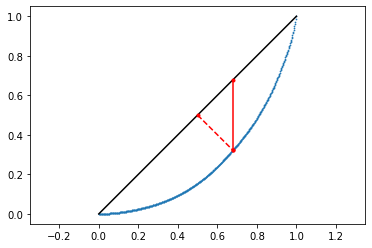

Lorenz gap: 0.36230444707595705
Lorenz gap CI at 0.95: [0.34017877260730806 , 0.3843874990740439]
Lorenz gap CI at 0.99: [0.33373626718916544 , 0.3907200753164606]

Jain FI: 0.49926597146344925
Jain FI CI at 0.95: [0.4597064619048515 , 0.5455210556193392]
Jain FI CI at 0.99: [0.4440223430775286 , 0.5565587979319865]

Mean: 4.084097581606042
Mean CI at 0.95: [3.736383203140016 , 4.432476242362438]
Mean CI at 0.99: [3.633763251790775 , 4.581265623242463]

Std: 4.090097677422348
Std CI at 0.95: [3.58328266881489 , 4.566238964006147]
Std CI at 0.99: [3.420664586163107 , 4.789451622620736]

Mean CI at 0.95: [3.7255913008639814 , 4.442603862348103]
Mean CI at 0.99: [3.612940463043766 , 4.555254700168319]



In [116]:
values = data_ex3.to_numpy()[:,0]
values = sorted(values)

print(f"CoV: {CoV(values)}")
print(f"Lorenz gap: {lorenz_gap(values)}")
print(f"Jain FI: {JFI(values)}")

# plot lorenz
n = len(values)
X = []
Y = []
tot = sum(values)
cum_sum = np.cumsum(values)
for i in np.arange(0, n, 1):
    X.append(i/n)
    Y.append(cum_sum[i]/tot)

scatter(X, Y, s=0.5)
# find intersection point calculating slope of line from (0.5,0.5) to each point of the curve, find the closest to -1
intersection_point = np.argmin([abs(-1 - (0.5-Y[i])/(0.5-X[i])) for i in range(len(X))])
x_i = X[intersection_point]
y_i = Y[intersection_point]
plt.axis('equal')
plt.plot([0,1], [0,1], 'k-')
plt.plot([0.5, x_i], [0.5, y_i], '.r--')
plt.plot([x_i, x_i], [y_i, x_i], '.r-')
plt.show()

print(f"Lorenz gap: {lorenz_gap(values)}")
interval = bootstrap(values, 0.95, lorenz_gap)
print(f"Lorenz gap CI at 0.95: [{interval[0]} , {interval[1]}]")
interval = bootstrap(values, 0.99, lorenz_gap)
print(f"Lorenz gap CI at 0.99: [{interval[0]} , {interval[1]}]\n")

print(f"Jain FI: {JFI(values)}")
interval = bootstrap(values, 0.95, JFI)
print(f"Jain FI CI at 0.95: [{interval[0]} , {interval[1]}]")
interval = bootstrap(values, 0.99, JFI)
print(f"Jain FI CI at 0.99: [{interval[0]} , {interval[1]}]\n")

print(f"Mean: {mean(values)}")
interval = bootstrap(values, 0.95, mean)
print(f"Mean CI at 0.95: [{interval[0]} , {interval[1]}]")
interval = bootstrap(values, 0.99, mean)
print(f"Mean CI at 0.99: [{interval[0]} , {interval[1]}]\n")

print(f"Std: {std(values)}")
interval = bootstrap(values, 0.95, std)
print(f"Std CI at 0.95: [{interval[0]} , {interval[1]}]")
interval = bootstrap(values, 0.99, std)
print(f"Std CI at 0.99: [{interval[0]} , {interval[1]}]\n")

# compare bootstrap mean with asymptotic mean
interval = mean_confidence_asymptotic(values, 0.95)
print(f"Mean CI at 0.95: [{interval[0]} , {interval[1]}]")
interval = mean_confidence_asymptotic(values, 0.99)
print(f"Mean CI at 0.99: [{interval[0]} , {interval[1]}]\n")

# bootstrap has smaller interval

## Exercise 4

Mean CI at 0.95 using bootstrap: [101.34620874544576 , 12439.603075972427]
Mean CI at 0.99 using bootstrap: [55.76948713008876 , 15794.38508917451]

Mean CI at 0.95 using asymptotic: [-3226.3420437613004 , 11612.994704202103]
Mean CI at 0.99 using asymptotic: [-5557.770818027488 , 13944.42347846829]



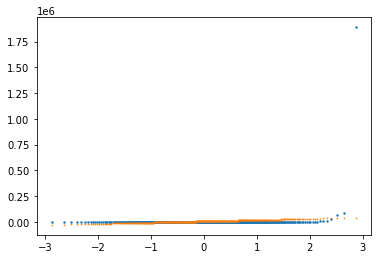

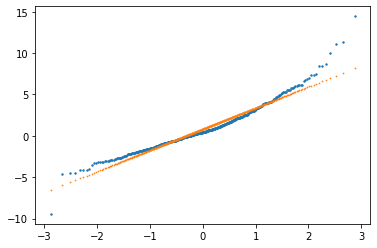

Mean CI at 0.95 using bootstrap: [0.6010722451879711 , 1.0420016635010183], re-transformed: [1.8240736063344845 , 2.8348858264200043]
Mean CI at 0.99 using bootstrap: [0.5332063687552184 , 1.128776577267232], re-transformed: [1.704388454623712 , 3.0918715193774644]

Mean CI at 0.95 using asymptotic: [0.5924332420947909 , 1.0491151025472925], re-transformed: [1.8083833006902783 , 2.8551235083706876]
Mean CI at 0.99 using asymptotic: [0.5206833217157347 , 1.1208650229263486], re-transformed: [1.6831774085012328 , 3.0675065194365163]



In [117]:
values = data_ex4.to_numpy()[:,0]
values = sorted(values)

# compare bootstrap and asymptotic
interval = bootstrap(values, 0.95, mean)
print(f"Mean CI at 0.95 using bootstrap: [{interval[0]} , {interval[1]}]")
interval = bootstrap(values, 0.99, mean)
print(f"Mean CI at 0.99 using bootstrap: [{interval[0]} , {interval[1]}]\n")

interval = mean_confidence_asymptotic(values, 0.95)
print(f"Mean CI at 0.95 using asymptotic: [{interval[0]} , {interval[1]}]")
interval = mean_confidence_asymptotic(values, 0.99)
print(f"Mean CI at 0.99 using asymptotic: [{interval[0]} , {interval[1]}]\n")

#plot QQ
X = []
Y = []
n = len(values)
for i in np.arange(0,n,1):
    X.append(norm.ppf((i+1)/(n+1)))
    Y.append(values[i])
X = np.array(X)
Y = np.array(Y)
m, b = np.polyfit(X, Y, 1)
plt.scatter(X, Y, s=2)
plt.scatter(X, m*X + b, s=0.5)
plt.show()

# log transform
Y_log = np.log(values)
m, b = np.polyfit(X, Y_log, 1)
plt.scatter(X, Y_log, s=2)
plt.scatter(X, m*X + b, s=0.5)
plt.show()

# compare bootstrap and asymptotic on log data
values = np.log(values)
interval = bootstrap(values, 0.95, mean)
print(f"Mean CI at 0.95 using bootstrap: [{interval[0]} , {interval[1]}], re-transformed: [{exp(interval[0])} , {exp(interval[1])}]")
interval = bootstrap(values, 0.99, mean)
print(f"Mean CI at 0.99 using bootstrap: [{interval[0]} , {interval[1]}], re-transformed: [{exp(interval[0])} , {exp(interval[1])}]\n")

interval = mean_confidence_asymptotic(values, 0.95)
print(f"Mean CI at 0.95 using asymptotic: [{interval[0]} , {interval[1]}], re-transformed: [{exp(interval[0])} , {exp(interval[1])}]")
interval = mean_confidence_asymptotic(values, 0.99)
print(f"Mean CI at 0.99 using asymptotic: [{interval[0]} , {interval[1]}], re-transformed: [{exp(interval[0])} , {exp(interval[1])}]\n")


## Exercise 5

In [118]:
values = data_ex5.to_numpy()[0]

# success = 1, failure = 0
n_success = sum(values)
print(f'There are {n_success}>=6 successes and {len(values)-n_success}>=6 failures. We can approximate using the normal approximation')
print(f"Probability of success (mean): {mean(values)}")
interval = success_probability_confidence_normal(values, 0.95)
print(f"Probability CI at 0.95: [{interval[0]} , {interval[1]}]")
interval = success_probability_confidence_normal(values, 0.99)
print(f"Probability CI at 0.99: [{interval[0]} , {interval[1]}]")

# using only the first 15
values = data_ex5.to_numpy()[0][:15]
n_success = sum(values)
print(f'There are {n_success} successes: we have to use the rule of three')
print(f"Probability of success (mean): {mean(values)}")
interval = success_probability_confidence_three(values, 0.95)
print(f"Probability CI at 0.95: [{interval[0]} , {interval[1]}]")
interval = success_probability_confidence_three(values, 0.99)
print(f"Probability CI at 0.99: [{interval[0]} , {interval[1]}]")

There are 125>=6 successes and 875>=6 failures. We can approximate using the normal approximation
Probability of success (mean): 0.125
Probability CI at 0.95: [0.10450220600861107 , 0.14549779399138893]
Probability CI at 0.99: [0.0980613323318191 , 0.1519386676681809]
There are 0 successes: we have to use the rule of three
Probability of success (mean): 0.0
Probability CI at 0.95: [0 , 0.21801936091053398]
Probability CI at 0.99: [0 , 0.2975781698474812]
